In [42]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [99]:
transform = transforms.Compose(
 [transforms.ToTensor(),
  torch.flatten
 ])

trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=False, num_workers=2)
classes = tuple(np.linspace(0,9,10, dtype=np.uint8))

In [240]:
class Net(nn.Module):
    def __init__(self, n_in=28 * 28, n_latent=20, n_h=200):
        super().__init__()
        self.enc1 = nn.Linear(n_in, n_h)
        #mean
        self.enc2 = nn.Linear(n_h, n_latent)
        #var
        self.enc3 = nn.Linear(n_h, n_latent)
        
        self.dec1 = nn.Linear(n_latent, n_h)
        self.dec2 = nn.Linear(n_h, n_in)
        
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z), mu, logvar
        
    def encode(self, x):
        h1 = F.relu(self.enc1(x))
        #mu, var
        return self.enc2(h1), self.enc3(h1)
    
    def decode(self, z):
        h3 = F.relu(self.dec1(z))
        return torch.sigmoid(self.dec2(h3))
        
        
def loss_fun(recon_x, x, mu, logvar):
    cross_ent = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar))
    
    return cross_ent + kl

In [241]:
torch.manual_seed(0)

net = Net()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [242]:
epochs = 10

for epoch in range(1, epochs + 1):
    train_loss = 0
    for train_idx, (inputs, _) in enumerate(trainloader):
        optimizer.zero_grad()
        recon, mu, logvar = net(inputs)
        
        loss = loss_fun(recon, inputs, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if train_idx % 100 == 99:
            print(f'Train Epoch {epoch} [{train_idx * len(inputs)}/{len(trainloader.dataset)}]\tLoss: {loss.item()/len(inputs)}')
            
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(trainloader.dataset)}')
    
    
    test_loss = 0
    with torch.no_grad():
        for i, (inputs, _) in enumerate(testloader):
            recon, mu, logvar = net(inputs)
            test_loss += loss_fun(recon, inputs, mu, logvar).item()
    
    test_loss /= len(testloader.dataset)
    print(f'====> Test set loss: {test_loss}')
        

Train Epoch 1 [9900/60000]	Loss: 196.17798828125
Train Epoch 1 [19900/60000]	Loss: 163.91482421875
Train Epoch 1 [29900/60000]	Loss: 160.73892578125
Train Epoch 1 [39900/60000]	Loss: 150.8265234375
Train Epoch 1 [49900/60000]	Loss: 134.815283203125
Train Epoch 1 [59900/60000]	Loss: 132.5655859375
====> Epoch: 1 Average loss: 170.2116751139323
====> Test set loss: 134.35466228841145
Train Epoch 2 [9900/60000]	Loss: 126.988388671875
Train Epoch 2 [19900/60000]	Loss: 128.623359375
Train Epoch 2 [29900/60000]	Loss: 129.661953125
Train Epoch 2 [39900/60000]	Loss: 123.3818359375
Train Epoch 2 [49900/60000]	Loss: 119.2434375
Train Epoch 2 [59900/60000]	Loss: 121.292578125
====> Epoch: 2 Average loss: 126.87443681640625
====> Test set loss: 121.92998802083333
Train Epoch 3 [9900/60000]	Loss: 119.09671875
Train Epoch 3 [19900/60000]	Loss: 116.029287109375
Train Epoch 3 [29900/60000]	Loss: 117.3044921875
Train Epoch 3 [39900/60000]	Loss: 116.905205078125
Train Epoch 3 [49900/60000]	Loss: 118.767

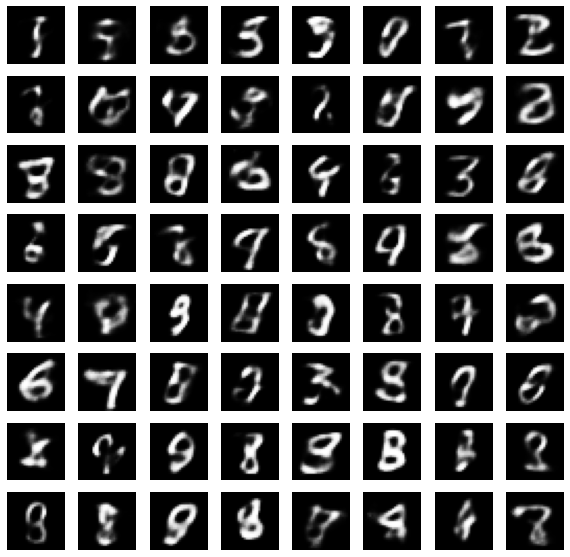

In [243]:
zz = torch.randn(64, 20)
zz = net.decode(zz).view(-1, 28, 28).detach()

row, col = 8, 8
plt.figure(figsize=(10, 10))

num = 0

while num < row * col:
    plt.subplot(row, col, num + 1)
    plt.imshow(zz[num], cmap='gray')
    plt.axis('off')
    num += 1

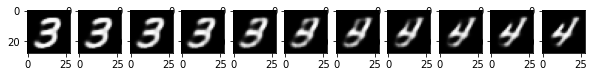

In [244]:
mu1, _ =  net.encode(trainset[9][0])
mu2, _ =  net.encode(trainset[7][0])

num = 0
plt.figure(figsize=(10, 10))

row, col = 1, 11

for t in np.arange(0, 1.05, 0.1):
    z = mu1 * t + mu2 * (1-t)
    out = net.decode(z).view(28, 28).detach()
    plt.subplot(row, col, num + 1)
    plt.imshow(out, cmap='gray')
    num += 1